File ‘ECG200_TRAIN.tsv’ already there; not retrieving.

File ‘ECG200_TEST.tsv’ already there; not retrieving.

   0         1         2         3         4         5         6         7   \
0  -1  0.502055  0.542163  0.722383  1.428885  2.136516  2.281149  1.936274   
1   1  0.147647  0.804668  0.367771  0.243894  0.026614 -0.274402  0.096731   
2  -1  0.316646  0.243199  0.370471  1.063738  1.678187  1.759558  1.697717   
3  -1  1.168874  2.075901  1.760141  1.606446  1.949046  1.302842  0.459332   
4   1  0.648658  0.752026  2.636231  3.455716  2.118157  0.520620 -0.188627   

         8         9   ...        87        88        89        90        91  \
0  1.468890  1.008845  ...  0.931043  0.610298  0.638894  0.684679  0.583238   
1 -0.747731 -1.609777  ... -0.533503 -0.400228  0.176084  1.111768  2.438428   
2  1.612159  1.168188  ...  0.764229  0.610621  0.552900  0.566786  0.604002   
3  0.516412  0.852180  ...  0.419006  0.723888  1.323947  2.136488  1.746597   
4  0.780818  0

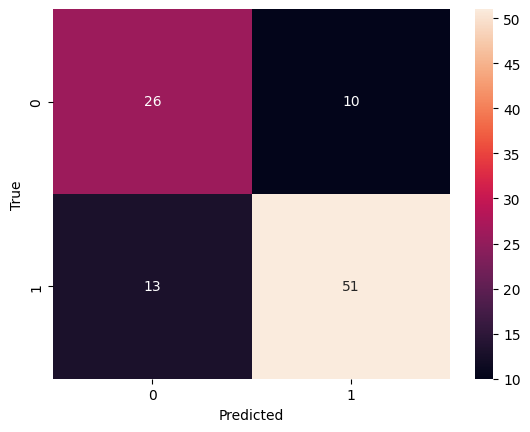

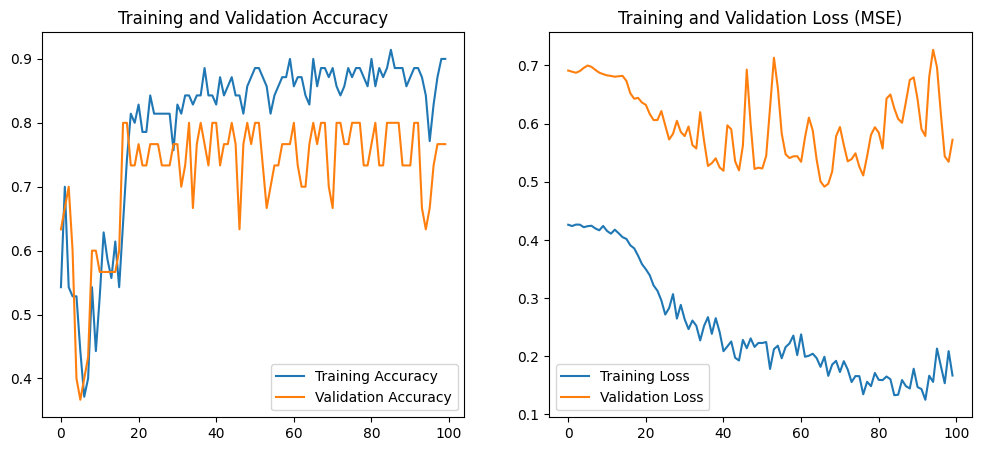

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.72      0.69        36
         1.0       0.84      0.80      0.82        64

    accuracy                           0.77       100
   macro avg       0.75      0.76      0.75       100
weighted avg       0.78      0.77      0.77       100



In [ ]:
from pandas import DataFrame
import pandas as pd
import tensorflow as tf
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import L1L2
import seaborn as sns
from math import sqrt
from matplotlib import pyplot as plt
import numpy as np

# Charger les données ECG200
!wget -nc https://maxime-devanne.com/datasets/ECG200/ECG200_TRAIN.tsv
!wget -nc https://maxime-devanne.com/datasets/ECG200/ECG200_TEST.tsv

rnn_train = "ECG200_TRAIN.tsv"
rnn_test = "ECG200_TEST.tsv"

data_train = pd.read_csv(rnn_train, sep='\t', header=None)
data_test= pd.read_csv(rnn_test, sep='\t', header=None)

print(data_train.head())
print(data_test.head())

X_train = data_train.iloc[:, 1:].values
y_train = (data_train.iloc[:, 0].values + 1) / 2

X_test = data_test.iloc[:,1:].values
y_test = (data_test.iloc[:, 0].values + 1) / 2

print(X_train)
print(X_test)

scaler = MinMaxScaler(feature_range=(0,1))
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_reshaped = X_train_normalized.reshape((X_train_normalized.shape[0], X_train_normalized.shape[1], 1))
X_test_reshaped = X_test_normalized.reshape((X_test_normalized.shape[0], X_test_normalized.shape[1], 1))

class_weights = {0: 1, 1: (len(y_train) - sum(y_train)) / sum(y_train)}

# Réseau de neurones Récurent (RNN) avec Dropout pour la classification des signaux ECG
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_reshaped,
    y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.3,
    class_weight=class_weights  # Utilisation des poids de classe
)

loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f'Accuracy: {accuracy}')

# Prédictions
y_pred = model.predict(X_test_reshaped)
y_pred = (y_pred > 0.5).astype(int).flatten()

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history.get('val_accuracy', [])
val_loss = history.history.get('val_loss', [])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
if val_accuracy:
    plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Créer le graphique pour le MSE
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
if val_loss:
    plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss (MSE)')
plt.legend()
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))